In [1]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy.ma as ma

import matplotlib.ticker as ticker

from mpl_toolkits.axes_grid1 import make_axes_locatable #for subplot colorbars
from matplotlib.pyplot import cm


# configure plotting
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 8, \
                            'figure.facecolor': (1, 1, 1, 0),'font.sans-serif':'Latin Modern Math'}

from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


%matplotlib inline

# Spatial maps

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

cmap = 'inferno_r'

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
def spatial_maps(a,mask):
    
    a[a <= 0] = 1e-32
    l = 3.3 * 100000
    c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
    
    mask = mask
    masked_map = ma.masked_array(a, mask=mask)
    masked_map = -(np.log(masked_map)/c) 
    
    return masked_map

# Loading data

In [4]:
os.chdir(
    '/media/nakul/Seagate Portable Drive/Data/DWS_Creep/DWS_Correlation_Outputs/Materials/Bustelo/02_18_2022/02_18_2022_A'
)

data = np.load('Bustelo_02_18_2022_A_Gmaps.npz')
correlation_maps_cumulative = data['data1']
correlation_maps_instantaneous = data['data2']
mask = data['data3']

Text(0.5, 1.0, '$\\dot{\\epsilon}[s^{-1}]$')

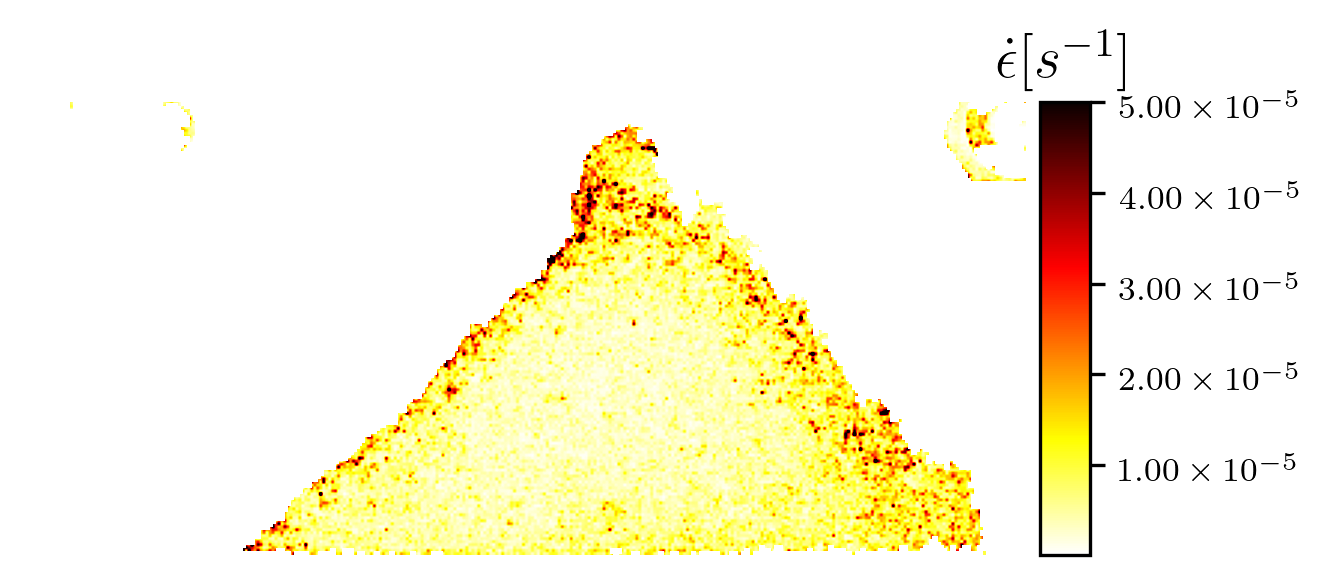

In [5]:
strain_map = spatial_maps(correlation_maps_cumulative[10][90], mask)

cmap = 'hot_r'
vmin = 1e-7
vmax = 5e-5

fig = plt.figure(figsize=(6, 2))
ax = plt.subplot(111)

im = ax.imshow(strain_map, vmin=vmin, vmax=vmax, cmap=cmap)
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im,
             cax=cax,
             orientation='vertical',
             format=ticker.FuncFormatter(fmt))
# cax.tick_params(labelsize=15)
cax.set_title(r'$\dot{\epsilon}[s^{-1}]$', fontsize=14)

# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.savefig(
#     '/home/nakul/Documents/Python Scripts/MaterialsBoundaries/Materials/PaperFigures/Maps_Materials/GlassBeads_02_15_2022_A_tw1_tau1_HAWT_r.svg',
#     bbox_inches='tight')

# Rotating and selecting region of interest

In [6]:
50 * 6 * 5.39e-5

0.01617

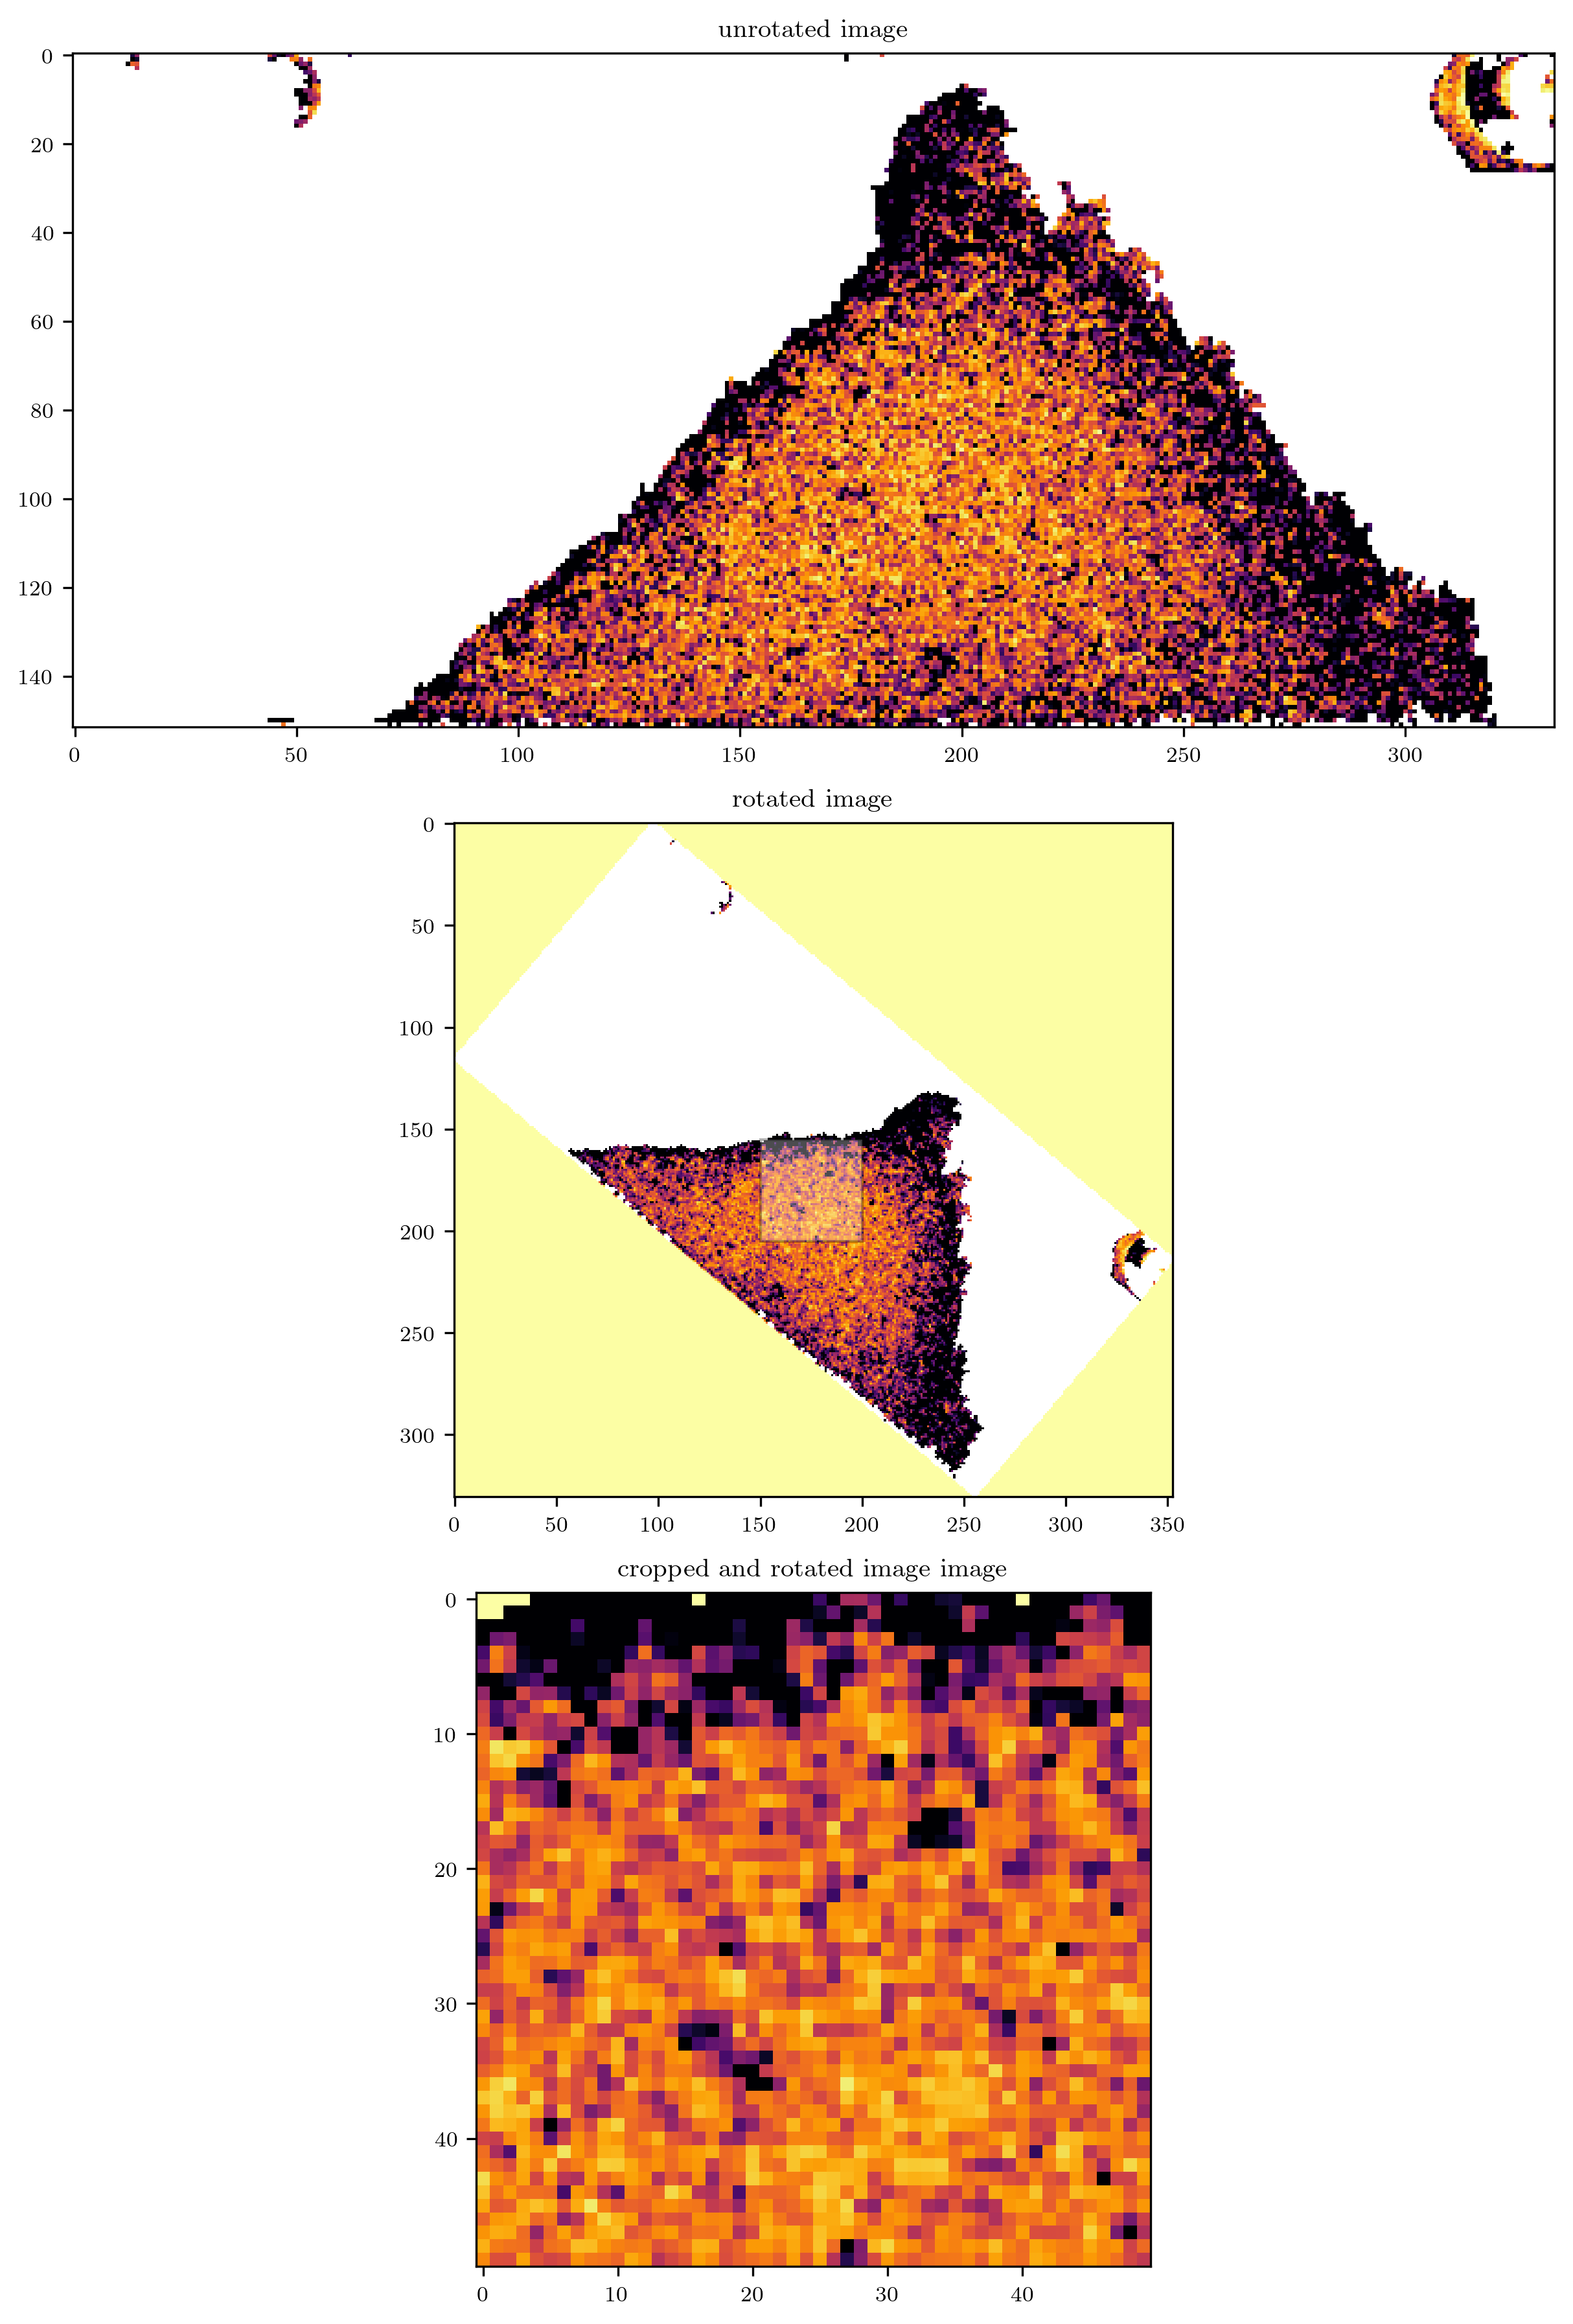

In [13]:
from skimage import transform

l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633



img = spatial_maps(correlation_maps_cumulative[10][90], mask)

x_min = 150
x_max = 200
y_min = 155
y_max = 205

rotation_angle = -40

# this is the depth, in metapixels
z = np.arange(.5,(y_max-y_min),1)
#depth in pixels
z = z*6
#depth in meters
z = z*5.39e-5

rotated_test = transform.rotate(img,rotation_angle,preserve_range = True,resize = True)
rotated_mask = transform.rotate(mask,rotation_angle,preserve_range = True,resize = True)
rotated_masked_image = ma.masked_array(rotated_test,mask = rotated_mask) 

roi_verts = [[y_max,x_max],[y_min,x_max],[y_min, x_min], [y_max, x_min]]
roi_verts.append(roi_verts[0])
x_roi, y_roi = zip(*roi_verts) 

cropped_rows = rotated_test[y_min:y_max,x_min:x_max].shape[0]

###################################################################################
fig = plt.figure(figsize=(12,12))


ax1 = plt.subplot(311)
ax1.imshow(img,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno_r')
# ax1.set_xlim([0,180])
# ax1.axis('off')
ax1.set_title('unrotated image')

ax2 = plt.subplot(312)
ax2.imshow(rotated_masked_image,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno_r')
ax2.fill(y_roi,x_roi,'w',alpha = .3,edgecolor = 'k') 
# ax2.axis('scaled')
ax2.set_title('rotated image')
# ax2.axis('off')

ax3 = plt.subplot(313)
ax3.imshow(rotated_test[y_min:y_max,x_min:x_max],vmin = 1e-7,vmax = 1e-5,cmap = 'inferno_r')
ax3.set_title('cropped and rotated image image')
# ax3.axis('off')

plt.tight_layout()

map_shape = rotated_test[y_min:y_max,x_min:x_max].shape

# Spatial Correlation

In [14]:
def autocorrelate(z_tile):
    #subtracting the mean 
    z_tile = z_tile-np.mean(z_tile)
    #take the fft
    z_fft   = 1/np.shape(z_tile)[1]/np.shape(z_tile)[0]*np.fft.fft2(z_tile)
    z_fft_r = (z_fft.real**2+z_fft.imag**2)**0.5
    
    #shift high modes to the middle, erase the lowest modes
    z_fft_s = np.fft.fftshift(z_fft_r)
    
    #get autocorrelation of the topo data via the inverse of the fft
    z_rft_s = np.fft.fftshift(np.fft.ifft2((z_fft)*np.conj((z_fft)))).real*np.shape(z_tile)[1]*np.shape(z_tile)[0]
    z_rft_s = z_rft_s/np.nanvar(z_tile)

    x = np.arange(np.shape(z_tile)[0])-np.shape(z_tile)[0]/2
    y = np.arange(np.shape(z_tile)[1])-np.shape(z_tile)[1]/2
    X,Y = np.meshgrid(x,y) 
    
    return z_rft_s#,X,Y

In [15]:
test = autocorrelate(rotated_test[y_min:y_max,x_min:x_max])

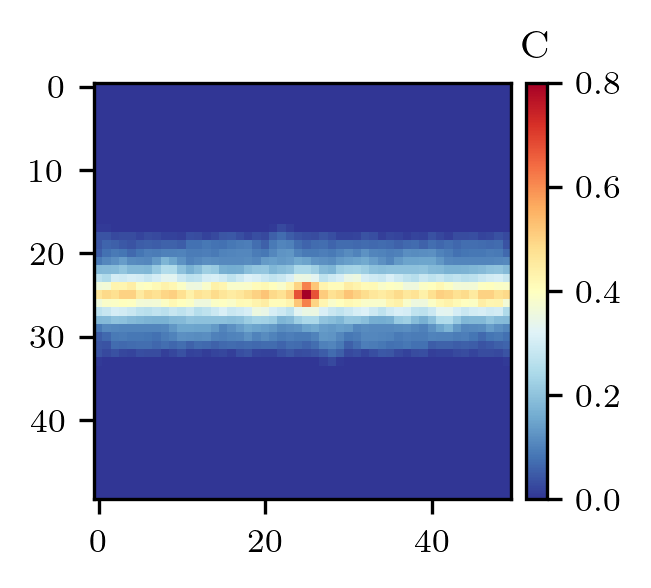

In [16]:
fig = plt.figure(figsize=(2.5,2))

cmap = 'RdYlBu_r'
vmin = 0
vmax = .8

ax = plt.subplot(111)

# im = ax.contour(test, vmin = vmin, vmax = vmax, colors = 'k',linewidths = 0.25)
# im = ax.contourf(test,vmin = vmin, vmax = vmax,cmap=cmap)

im = ax.imshow(test,vmin = vmin,vmax = vmax, cmap = cmap)

# ax.set_aspect('.55')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
cax.set_title('C')
# cax.tick_params(labelsize=15)
# ax.set_aspect(.5)

fig.tight_layout()

# plt.savefig('/home/nakul/Documents/Python Scripts/MaterialsBoundaries/Materials/PaperFigures/Maps_Boundaries/correlation_test.svg', bbox_inches='tight')

## multiple strain maps

In [17]:
def crop_rotate(correlation_map):

    img  = spatial_maps(correlation_map, mask)
    rotated_test = transform.rotate(img,rotation_angle,preserve_range = True,resize = True)

    return rotated_test[y_min:y_max,x_min:x_max]

In [18]:
map1 = crop_rotate(correlation_maps_cumulative[4][1])
map2 = crop_rotate(correlation_maps_cumulative[4][3])
map3 = crop_rotate(correlation_maps_cumulative[4][6])
map4 = crop_rotate(correlation_maps_cumulative[4][9])
map5 = crop_rotate(correlation_maps_cumulative[4][10])

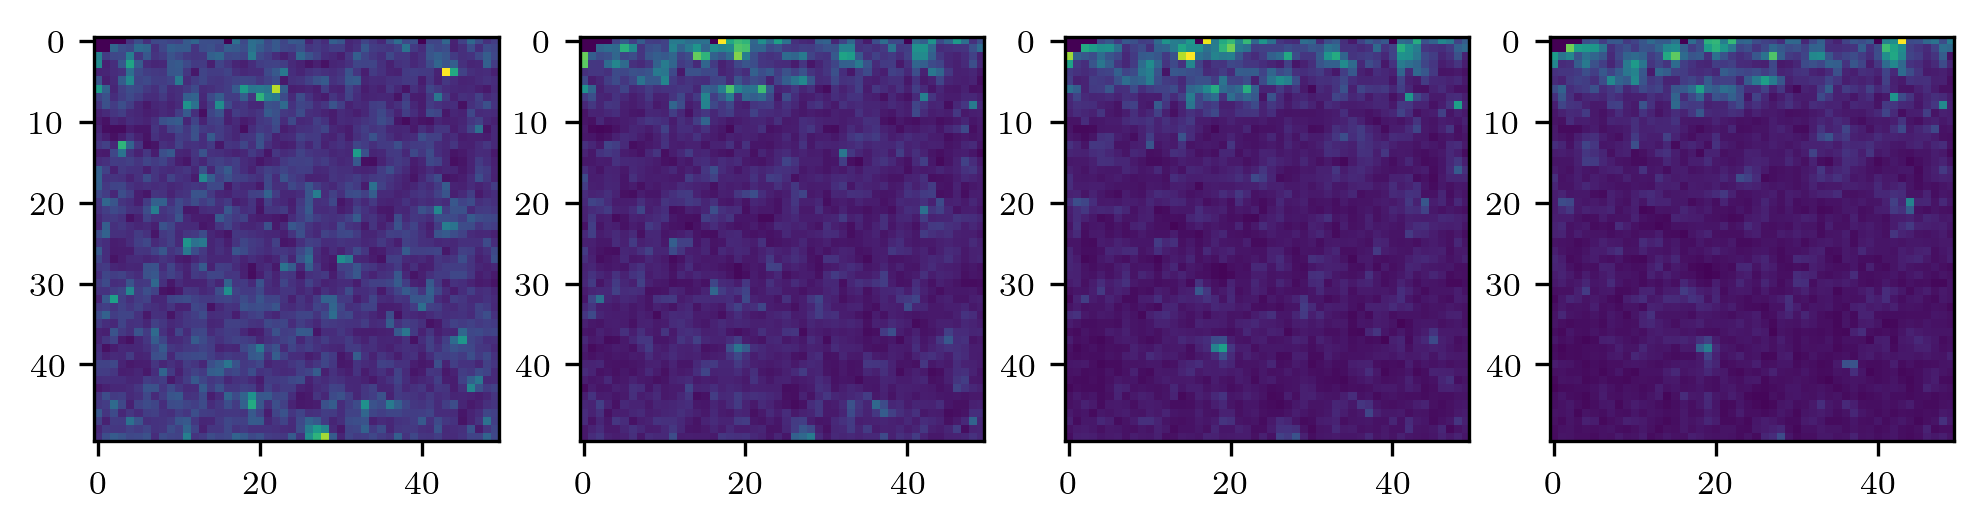

In [19]:
fig = plt.figure(figsize=(8,2))

ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)
# ax5 = plt.subplot(155)

ax1.imshow(map1)
ax2.imshow(map2)
ax3.imshow(map3)
ax4.imshow(map4)
# ax5.imshow(map5)

In [20]:
corr1 = autocorrelate(map1)
corr2 = autocorrelate(map2)
corr3 = autocorrelate(map3)
corr4 = autocorrelate(map4)
# corr5 = autocorrelate(map5)

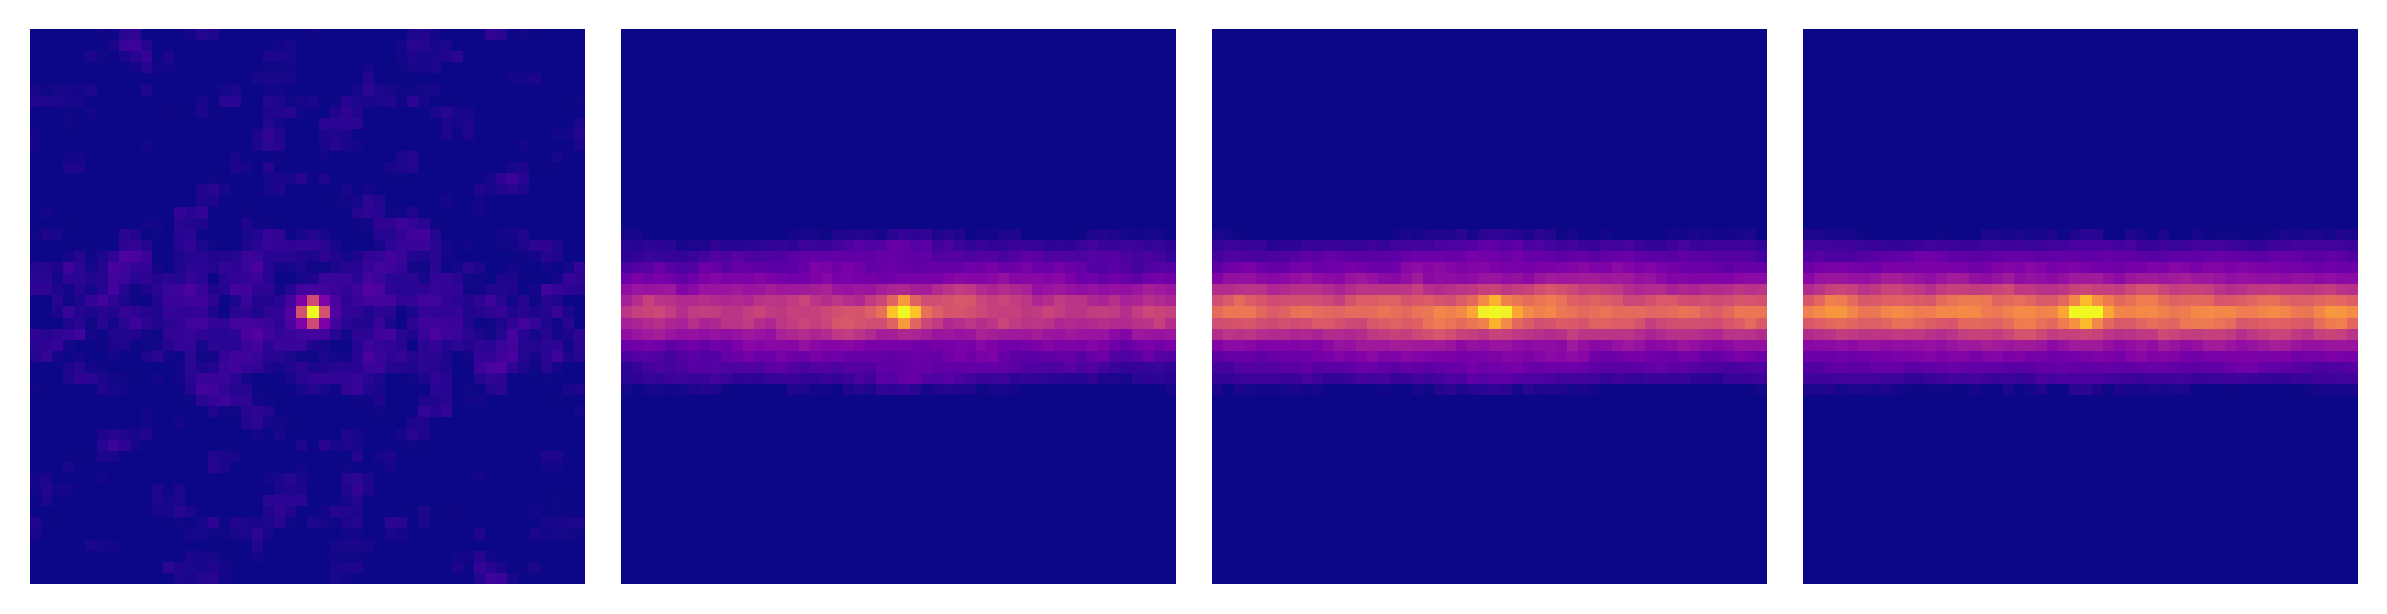

In [21]:
cmap = 'plasma'
vmin = 0
vmax = .7

fig = plt.figure(figsize=(8, 4))

ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)
# ax5 = plt.subplot(155)

ax1.imshow(corr1,vmin=vmin,vmax=vmax,cmap = cmap)
ax2.imshow(corr2,vmin=vmin,vmax=vmax,cmap = cmap)
ax3.imshow(corr3,vmin=vmin,vmax=vmax,cmap = cmap)
ax4.imshow(corr4,vmin=vmin,vmax=vmax,cmap = cmap)
# ax5.imshow(corr5,vmin=vmin,vmax=vmax,cmap = cmap)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
# ax5.axis('off')

fig.tight_layout()

# plt.savefig('/home/nakul/Documents/Python Scripts/MaterialsBoundaries/PaperFigures/Fig4_Quadrupoles/glassbeads_quadrupoles.svg', bbox_inches='tight')

In [22]:
# this is the depth, in metapixels
z = np.arange(0,50,1)
#depth in pixels
z = z*6
#depth in meters
z = z*5.39e-5

In [23]:
z

array([0.       , 0.0003234, 0.0006468, 0.0009702, 0.0012936, 0.001617 ,
       0.0019404, 0.0022638, 0.0025872, 0.0029106, 0.003234 , 0.0035574,
       0.0038808, 0.0042042, 0.0045276, 0.004851 , 0.0051744, 0.0054978,
       0.0058212, 0.0061446, 0.006468 , 0.0067914, 0.0071148, 0.0074382,
       0.0077616, 0.008085 , 0.0084084, 0.0087318, 0.0090552, 0.0093786,
       0.009702 , 0.0100254, 0.0103488, 0.0106722, 0.0109956, 0.011319 ,
       0.0116424, 0.0119658, 0.0122892, 0.0126126, 0.012936 , 0.0132594,
       0.0135828, 0.0139062, 0.0142296, 0.014553 , 0.0148764, 0.0151998,
       0.0155232, 0.0158466])

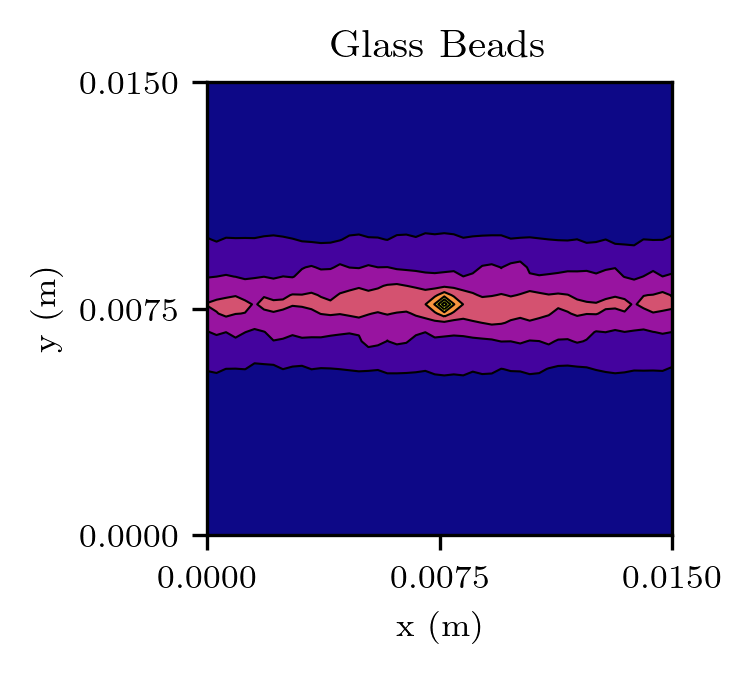

In [24]:
fs = 8
ls = 8

extent = [0,0.015,0,0.015]

fig = plt.figure(figsize=(2, 2))

ax1 = plt.subplot(111)



c1 = ax1.contour(corr2,vmin=vmin,vmax=vmax,colors='black',linewidths = .5,extent = extent)
cf1 = ax1.contourf(corr2,vmin=vmin,vmax=vmax,cmap = cmap,extent = extent)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(cf1, cax=cax, orientation='vertical')
# cax.set_title('C')

ax1.set_xticks([0,0.0075,0.015])
ax1.set_yticks([0,0.0075,0.015])

ax1.set_title("Glass Beads")

ax1.set_xticks([0,0.0075,0.015])
ax1.set_yticks([0,0.0075,0.015])

ax1.set_ylabel(r'y (m)', fontsize = fs)
ax1.set_xlabel(r'x (m)',fontsize = fs)

ax1.tick_params(axis='both', which='major', labelsize=ls)
ax1.tick_params(axis='both', which='minor', labelsize=ls)


# plt.savefig('/home/nakul/Documents/NaturalPhilosophy/Manuscripts/Materials_Boundaries/Figures/PaperFigures/Fig4_Quadrupoles/GlassBeadsQuadrupole.svg', bbox_inches='tight')

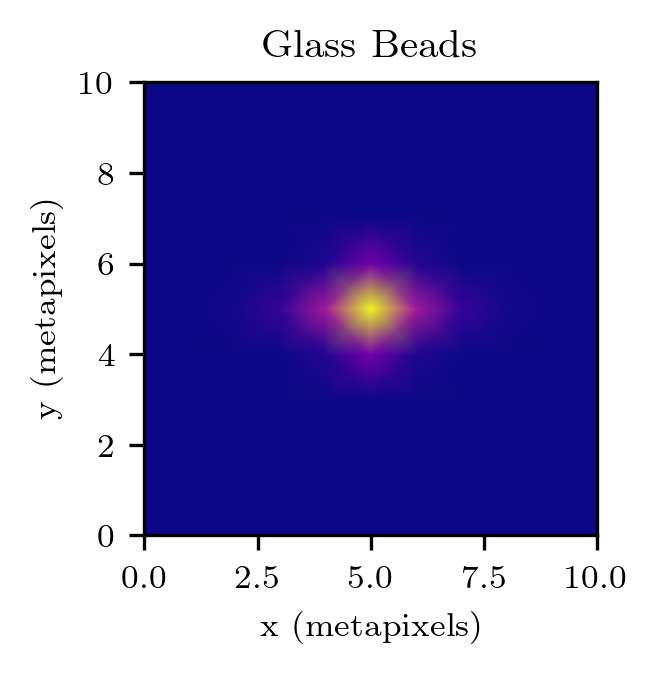

In [25]:
fs = 8
ls = 8

# cmap =  'nipy_spectral'
cmap =  'plasma'

extent = [0,0.015,0,0.015]

fig = plt.figure(figsize=(2, 2))
ax1 = plt.subplot(111)

xmin = 20
xmax = 31
ymin = 20
ymax = 31

vmin = 0.4
vmax = 1

im2 = ax1.imshow(corr2,vmin=vmin,vmax=vmax,cmap = cmap,extent = extent,alpha = 1)
im1 = ax1.pcolormesh(corr2[ymin:ymax,xmin:xmax],vmin=vmin,vmax=vmax,shading='gouraud',cmap = cmap)
# c1 = ax1.contour(corr2[ymin:ymax,xmin:xmax],colors = 'black',alpha = 0.1,extent = extent)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical')
# cax.set_title('C')

# ax1.set_xticks([0,0.0075,0.015])
# ax1.set_yticks([0,0.0075,0.015])

ax1.set_title("Glass Beads")

# ax1.set_xticks([0,0.0075,0.015])
# ax1.set_yticks([0,0.0075,0.015])

ax1.set_ylabel(r'y (metapixels)', fontsize = fs)
ax1.set_xlabel(r'x (metapixels)',fontsize = fs)

ax1.tick_params(axis='both', which='major', labelsize=ls)
ax1.tick_params(axis='both', which='minor', labelsize=ls)



# plt.tight_layout()


# plt.savefig('/home/nakul/Documents/NaturalPhilosophy/Manuscripts/Materials_Boundaries/Figures/PaperFigures/Fig4_Quadrupoles/GlassBeadsQuadrupole_zoomed.png', bbox_inches='tight')

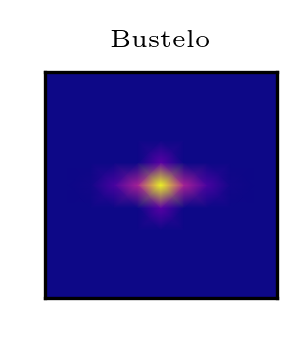

In [28]:
fs = 8
ls = 8

cmap =  'plasma'


fig = plt.figure(figsize=(1, 1))
ax1 = plt.subplot(111)

xmin = 20
xmax = 31
ymin = 20
ymax = 31

vmin = 0.5
vmax = 1

im1 = ax1.pcolormesh(corr3[ymin:ymax,xmin:xmax],vmin=vmin,vmax=vmax,shading='gouraud',cmap = cmap)

ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title("Bustelo", fontsize=6)

# plt.tight_layout()


plt.savefig('/home/nakul/Documents/NaturalPhilosophy/Manuscripts/Materials_Boundaries/Figures/PaperFigures/Fig4_Quadrupoles/MaterialFrames/Bustelo_Quadrupole.png', bbox_inches='tight')

#### Movies

In [ ]:
fig = plt.figure(figsize=(6, 2))

from mpl_toolkits.axes_grid1 import make_axes_locatable
l = 3.3 * 100000
c = ((8 * np.pi) * (np.sqrt(2 / 5)) * l) / 633
n = 0
time = np.arange(0, 1000, 1)

for i in range(99):

    ########################################################################################
    fig = plt.figure(figsize=(6, 2))
    ax1 = plt.subplot(111)
    ########################################################################################
    frame = correlation_maps_instantaneous[i][1]
    masked_map = ma.masked_array(frame, mask=mask)
    masked_map[masked_map <= 0] == 1e-32
    masked_map = -(np.log(masked_map) / c)
    im1 = ax1.imshow(masked_map, vmin=1e-7, vmax=5e-5, cmap='inferno_r')
    cmap = plt.cm.gray
    cmap.set_bad('white', 1.)
    ########################################################################################
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1,
                 cax=cax,
                 orientation='vertical',
                 format=ticker.FuncFormatter(fmt))
    # cax.tick_params(labelsize=15)
    cax.set_title(r'$\dot{\epsilon}[s^{-1}]$', fontsize=14)
    ax1.axis('off')
    ########################################################################################
    fig.tight_layout()

    plt.savefig(
        "/home/nakul/Documents/StrainMaps/img_"
        + str(n) + ".png",
        format="PNG")
    plt.clf()
    n += 1